### Shadow Art

[Shadow Art](https://dl.acm.org/doi/10.1145/1618452.1618502) is the design of a 3D object based only on the shadows it casts.

This notebook uses the differentiable shadow mapping framework for shadow art: an object is deformed until its cast shadow resembles a target shadow.

##### Create a Context for Differentiable Rendering and a Renderer

First import the necessary packages, then create a render context for `nvdiffrast` and a `SimpleRenderer` instance.

In [1]:
import imageio
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from diffshadow import *
from diffshadow.simple_renderer import SimpleRenderer, Mesh, load_mesh, create_plane_mesh, DirectionalLight, weld_seams, Camera
from utilities import *

def load_shadow_image(img_path, device):
    img = imageio.imread(img_path)
    if len(img.shape) == 2:
        img = img[:, :, None]
    elif len(img.shape) == 3:
        img = img[:, :, 0:1]
    return vflip(torch.tensor(img, dtype=torch.float32, device=device) / 255.0)

# Select a device (GPU 0) and create a context for nvdiffrast
device         = torch.device('cuda:0')
render_context = dr.RasterizeGLContext(device=device)
renderer       = SimpleRenderer(render_context)

##### Define the Scene and Target Shadows

The one-view shadow art scene is composed of a shadow receiver plane, an object that casts a shadow, a camera pointing at the plane and a directional light.

First, expose a set of parameters that control the configuration of the receiver plane, the camera focusing the plane and the target shadow.

In [2]:
# NOTE: A planar receiver is used by default, but shadows can be cast on any geometry.
#       By setting `use_wavegrid_plane_mesh = True`, the receiver will become a curved 'wavegrid'.
use_wavegrid_plane_mesh = False

# NOTE: An orthogonal camera co-located with the light is used by default, but any camera can view the shadow receiver from an arbitrary location.
#       By setting `use_perspective_plane_camera = True`, the camera will become a perspective camera observing the receiver from the side. 
use_perspective_plane_camera = False

# The target shadow is loaded from an image file
target_shadow_path = "./data/shadow_art_target_bunny.png"

Now define the shadow receiver plane with its geometry and camera, and load the reference shadow. Also define a couple of convenience functions for rendering the shadow image and a debug image to visualize the complete scene.

c:\Users\mworchel\Documents\work\code\differentiable-shadow-mapping\diffshadow\simple_renderer\mesh_io.py:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  vertex_normals = torch.from_numpy(mesh.vertex_normals).to(device, dtype=torch.float32)
c:\Users\mworchel\Miniconda3\envs\diffshadow_dev\lib\site-packages\torch\nn\functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


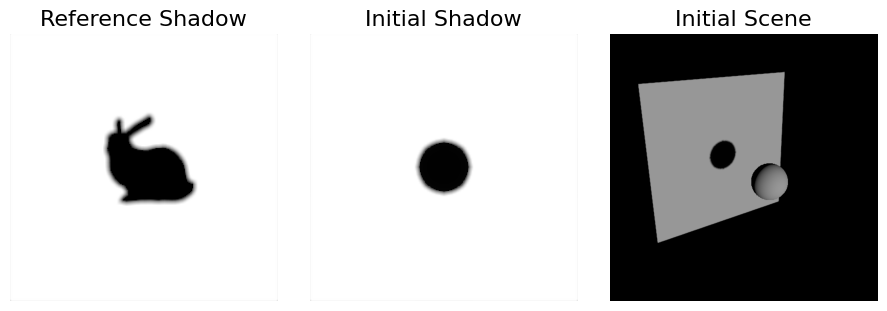

In [3]:
# Load the initial mesh (a sphere in this case)
base_mesh = Mesh(*load_mesh("./data/sphere.obj", device=device, normalize=False))

plane_data = [{
    'mesh':              create_plane_mesh([0, 0, -2], [0, 0, 1], size=2, device=device),
    'view_matrix':       create_lookat_matrix(eye=[0.0, 0.0, 0.0], focus=[0.0, 0.0, -2.0], up=[0.0, 1.0, 0.0]).to(device),
    'projection_matrix': create_orthographic_projection_matrix(near=0.1, far=10.0, size=2.0, device=device),
    'light':             DirectionalLight(torch.tensor([0.0, 0.0, 1.0], device=device)),
    'object_offset':     torch.tensor([[0, 0, 2]], device=device),
    'reference':         load_shadow_image(target_shadow_path, device)
}]

if use_perspective_plane_camera:
    plane_data[0]['view_matrix']       = create_lookat_matrix(eye=[-4.0, 0.0, 0.0], focus=[0.0, 0.0, -2.0], up=[0.0, 1.0, 0.0]).to(device)
    plane_data[0]['projection_matrix'] = create_perspective_projection_matrix(fovy=45, near=0.1, far=10.0, device=device)

    # Slighly move the reference shadow horizontally to center it in the perspective camera
    plane_data[0]['reference'] = torch.roll(plane_data[0]['reference'], shifts=-15, dims=1)
        
if use_wavegrid_plane_mesh:
    wavegrid_mesh = weld_seams(Mesh(*load_mesh("./data/wavegrid.obj", device=device, normalize=False)))
    wavegrid_mesh.vertices[:, :2] *= 2
    if use_perspective_plane_camera:
        # The wavegrid has occlusions when viewed from the side, so rotate it slightly towards the camera
        R = create_rotation_matrix(math.radians(-35), 0, 2, device=device)
        wavegrid_mesh = wavegrid_mesh.with_vertices(apply_transformation(wavegrid_mesh.vertices, R, mode='euclidean'))
    wavegrid_mesh.vertices[:, 2] -= 2
    plane_data[0]['mesh'] = wavegrid_mesh

# A convenience function for rendering the visibility image for plane i
def render_for_plane(mesh: Mesh, i: int):
    # Define the camera looking at the plane
    camera = Camera(view_matrix=plane_data[i]['view_matrix'], projection_matrix=plane_data[i]['projection_matrix'])

    # Move the mesh out of the camera view (note: only valid for directional lights)
    mesh_with_offset = mesh.with_vertices(mesh.vertices + plane_data[i]['object_offset'])

    smoothing_kernel_width = 5
    _, visibilities, mask = renderer.render(meshes=[mesh_with_offset, plane_data[i]['mesh']], lights=[plane_data[i]['light']], camera=camera, ambient=0.0, resolution=(256, 256), smoothing_kernel_width=smoothing_kernel_width, return_visibility=True, return_mask=True)

    return visibilities[0], mask

# A convenience function for rendering a debug view of the complete scene with all planes
def render_debug_scene(mesh: Mesh):
    camera = Camera(
        view_matrix=create_lookat_matrix(eye=[-4, 3, 5], focus=[0, 0, -1], up=[0, 1, 0]).to(device), 
        projection_matrix=create_perspective_projection_matrix(fovy=45, device=device, far=15)
    )

    plane_meshes = [plane['mesh'] for plane in plane_data]
    plane_lights = [plane['light'] for plane in plane_data]

    img = renderer.render(meshes=[mesh]+plane_meshes, lights=plane_lights, camera=camera, ambient=0.0, resolution=(512, 512))

    return img

plot(plane_data[0]['reference'], render_for_plane(base_mesh, 0)[0], render_debug_scene(base_mesh), titles=[
    "Reference Shadow", "Initial Shadow", "Initial Scene"
], title_args={'fontsize': 16}, axis_off=True)

##### Run the Optimization

Perform an image-based optimization, where a reference shadow is compared to the object's shadow as observed by a camera focusing the shadow receiver plane. The mesh is evolved using gradient descent with the gradient preconditioning by [Nicolet et al.](https://bnicolet.com/publications/Nicolet2021Large.html)

100%|██████████| 400/400 [00:06<00:00, 63.40it/s, loss=3.26e-5] 


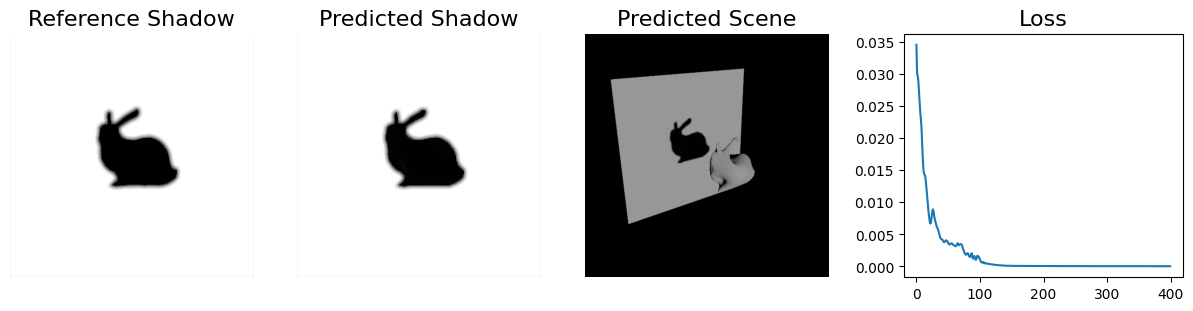

In [4]:
from largesteps.geometry import compute_matrix
from largesteps.parameterize import to_differential, from_differential
from largesteps.optimize import AdamUniform

# Compute the system matrix
v = base_mesh.vertices.clone()
M = compute_matrix(v, base_mesh.faces, lambda_=20)

# Parameterize
u_opt = to_differential(M, v)
u_opt.requires_grad = True
optimizer = AdamUniform([u_opt], lr=0.2)

shadows_opt = []
imgs_debug = []
losses = []
progress_bar = tqdm(range(400))
for iteration in progress_bar:
    # Get vertex coordinates from the parameterization
    v_opt = from_differential(M, u_opt, 'Cholesky')

    # Get the current mesh
    mesh_opt = base_mesh.with_vertices(v_opt)

    # Compute the loss, averaging the shadow difference from all planes
    loss = 0
    for i in range(len(plane_data)):
        shadow_ref   = plane_data[i]['reference']
        shadow, mask = render_for_plane(mesh_opt, i)
        loss += torch.mean(((shadow-shadow_ref)[mask > 0])**2)
    loss /= len(plane_data)

    # NOTE: a normal consistency loss is not used in this example

    progress_bar.set_postfix({'loss': float(loss.detach().cpu())})
    losses += [float(loss.detach().cpu())]

    # Save every n-th image
    if iteration % 2 == 0:
        with torch.no_grad():
            shadows_opt += [ render_for_plane(mesh_opt, 0)[0].cpu() ]
            imgs_debug  += [ render_debug_scene(mesh_opt).cpu() ]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plot(plane_data[0]['reference'], shadows_opt[-1], imgs_debug[-1], losses, titles=[
    "Reference Shadow", "Predicted Shadow", "Predicted Scene", "Loss"
], title_args={'fontsize':16}, axis_off=True)

Create a video showing the optimization

In [5]:
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='html5')

fig, axs = plt.subplots(1, 4, figsize=(16,4))
axs[0].set_axis_off()
axs[0].set_title("Reference Shadow")
axs[1].set_axis_off()
axs[1].set_title("Predicted Shadow")
axs[2].set_axis_off()
axs[2].set_title("Shadow Error")
axs[3].set_axis_off()
axs[3].set_title("Debug View")
_ = axs[0].imshow(to_display_image(plane_data[0]['reference'], grayscale_to_rgb=True))
im1 = axs[1].imshow(to_display_image(shadows_opt[0], grayscale_to_rgb=True))
im2 = axs[2].imshow(to_display_image(shadows_opt[0] - plane_data[0]['reference'].cpu(), gamma=False), cmap='coolwarm', vmin=-0.5, vmax=0.5)
im3 = axs[3].imshow(to_display_image(imgs_debug[0], grayscale_to_rgb=True))

def animate(i):
    im1.set_array(to_display_image(shadows_opt[i], grayscale_to_rgb=True))
    im2.set_array(to_display_image(shadows_opt[i] - plane_data[0]['reference'].cpu(), gamma=False))
    im3.set_array(to_display_image(imgs_debug[i], grayscale_to_rgb=True))
    return [im1, im3]

anim = animation.FuncAnimation(fig, animate, frames=len(shadows_opt), interval=1000/30, blit=False)
plt.close(fig)

HTML(anim.to_html5_video())